### Setting up logging

In [1]:
import logging

logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

### Exploring test data

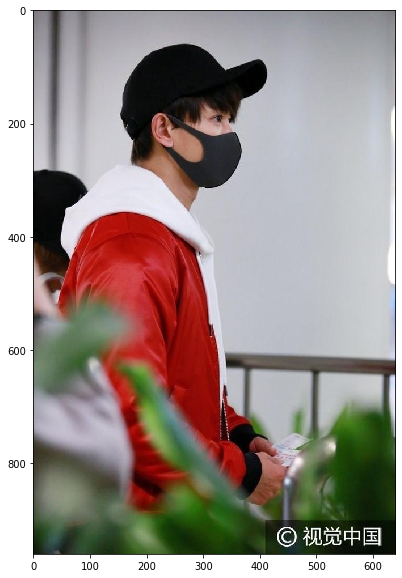

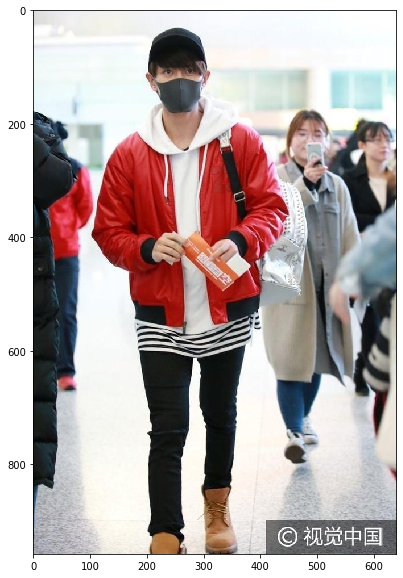

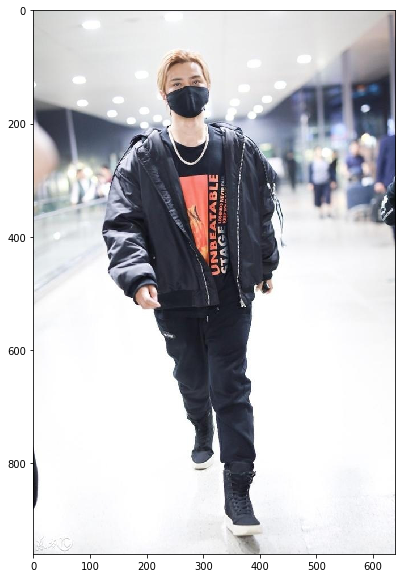

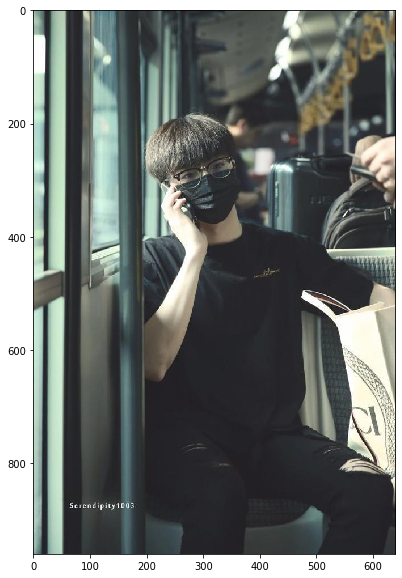

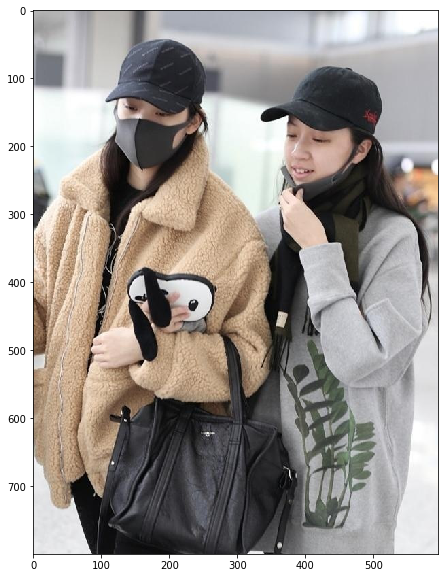

In [2]:
import os
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageColor
import numpy as np

for root, _, files in os.walk('/root/no-code-low-code/hcls/vision/mask-detection/test/'):
    for file_ in files:
        img_jpg = f'{root}/{file_}'
        
        with open(img_jpg, 'rb') as file: input_img = file.read()

        image_np = np.array(Image.open(img_jpg))
        plt.figure(figsize=(20,10))
        ax = plt.axes()
        ax.imshow(image_np)


### Helpers to invoke SageMaker endpoint and parse the response

In [3]:
import boto3
import json

def query_endpoint(input_img):
    endpoint_name = 'jumpstart-ftc-mx-od-ssd-512-vgg16-atrous-voc'
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=input_img, Accept='application/json;verbose;n_predictions=2')
    # If we remove ';n_predictions=20' from Accept, we get all the predicted boxes.  
    model_predictions = json.loads(response['Body'].read())
    return model_predictions

def parse_response(model_predictions):    
    normalized_boxes, classes, scores, labels = model_predictions['normalized_boxes'], model_predictions['classes'], model_predictions['scores'], model_predictions['labels']
    # Substitute the classes index with the classes name
    class_names = [labels[int(idx)] for idx in classes]
    return normalized_boxes, class_names, scores


### Getting predictions for all test images

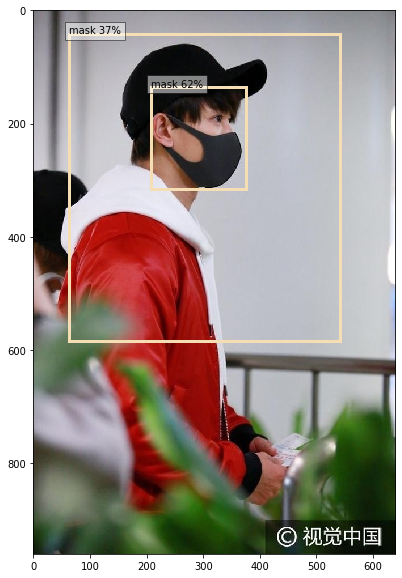

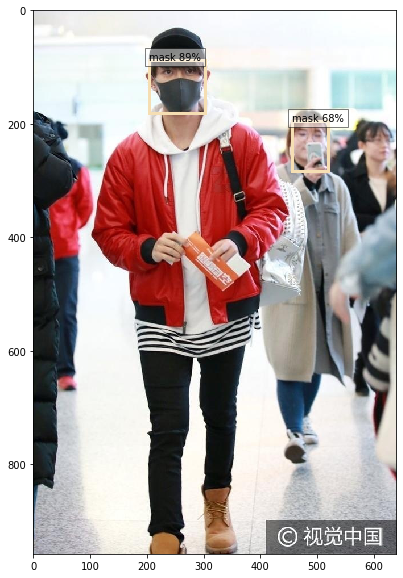

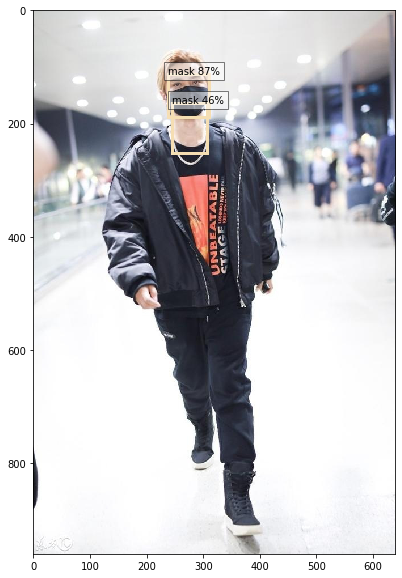

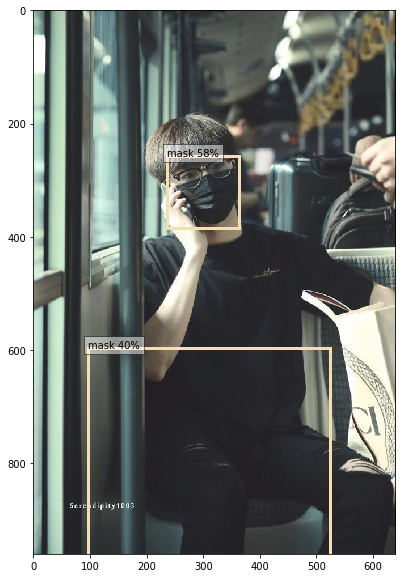

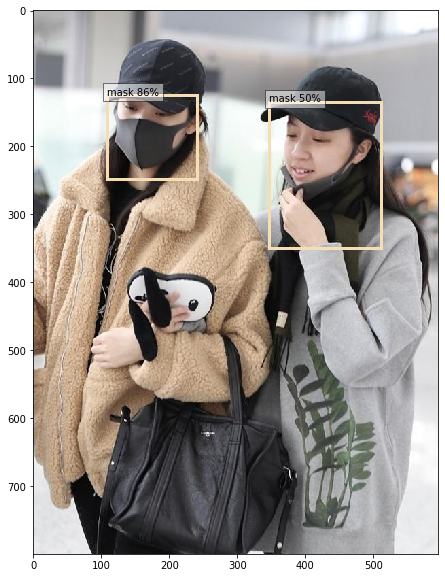

In [5]:
import matplotlib.patches as patches

colors = list(ImageColor.colormap.values())

for root, _, files in os.walk('./test/'):
    for file_ in files:
        img_jpg = f'{root}/{file_}'
        
        with open(img_jpg, 'rb') as file: input_img = file.read()
        best_results_per_input = parse_response(query_endpoint(input_img))

        image_np = np.array(Image.open(img_jpg))
        plt.figure(figsize=(20,10))
        ax = plt.axes()
        ax.imshow(image_np)
        normalized_boxes, classe_names, confidences = best_results_per_input
        for idx in range(len(normalized_boxes)):
            left, bot, right, top = normalized_boxes[idx]
            x, w = [val * image_np.shape[1] for val in [left, right - left]]
            y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
            color = colors[hash(classe_names[idx]) % len(colors)]
            rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, "{} {:.0f}%".format(classe_names[idx], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))